In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import urllib.request
import requests
import json
import os

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# !wget https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py
import choroplethNYC as cp

--2018-07-08 14:11:36--  https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py
Resolving raw.githubusercontent.com... 151.101.20.133
Connecting to raw.githubusercontent.com|151.101.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2606 (2.5K) [text/plain]
Saving to: 'choroplethNYC.py.2'

choroplethNYC.py.2  100%[===================>]   2.54K  --.-KB/s    in 0s      

2018-07-08 14:11:36 (13.7 MB/s) - 'choroplethNYC.py.2' saved [7747]



In [3]:
#urllib.request.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', "file.gz")
#os.system("mv " + "file.gz " + os.getenv("PUIDATA"))
#os.system("unzip " + os.getenv("PUIDATA") + "/file.gz -d " + os.getenv("PUIDATA") + "/zipcode")
nyc = gpd.read_file(os.getenv("PUIDATA") + "/zipcode" + "/ZIP_CODE_040114.shp")
nyc.drop(['BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)
nyc.rename({'ZIPCODE': 'zipcode'}, axis='columns', inplace=True)
nyc['zipcode'] = nyc['zipcode'].astype('str')
# nyc.head(2)

# CityBike

In [4]:
df = pd.read_csv("Transportation_standardize_rmean/citi_rmean.csv", index_col=0)
# df.head()

In [5]:
df1 = df.T.reset_index()
df1.rename({'index': 'zipcode'}, axis='columns', inplace=True)
df1['zipcode'] = df1['zipcode'].astype('str')
df1.head(2)

zipcode    5/1/14    6/1/14    7/1/14    8/1/14    9/1/14   10/1/14  \
0      83 -0.803328 -0.805522 -0.810214 -0.812990 -0.815115 -0.820844   
1   10001 -0.703968 -0.575336 -0.513527 -0.494823 -0.479735 -0.508157   

    11/1/14   12/1/14    1/1/15    ...       3/1/17    4/1/17    5/1/17  \
0 -0.821933 -0.822130 -0.821967    ...     0.679305  0.788591  0.859629   
1 -0.533669 -0.533222 -0.530806    ...     0.350857  0.387955  0.454608   

     6/1/17    7/1/17    8/1/17    9/1/17   10/1/17   11/1/17   12/1/17  
0  0.922184  1.021657  1.067643  1.079237  1.103953  1.100593  1.104000  
1  0.486964  0.506605  0.520200  0.539867  0.563652  0.566082  0.569356  

[2 rows x 45 columns]

In [6]:
X = df1.iloc[:,1:]
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)

In [7]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.4244112424690107
For n_clusters = 3, the average silhouette_score is : 0.5026361173143564
For n_clusters = 4, the average silhouette_score is : 0.5955048650828395
For n_clusters = 5, the average silhouette_score is : 0.6093014249039137
For n_clusters = 6, the average silhouette_score is : 0.4980961811476585
For n_clusters = 7, the average silhouette_score is : 0.5717302519656825


In [8]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 45)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

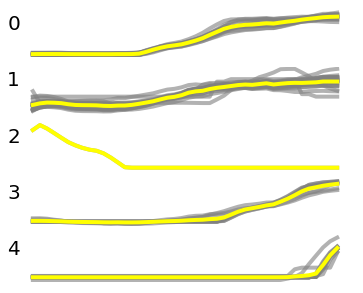

Total 63 zipcodes


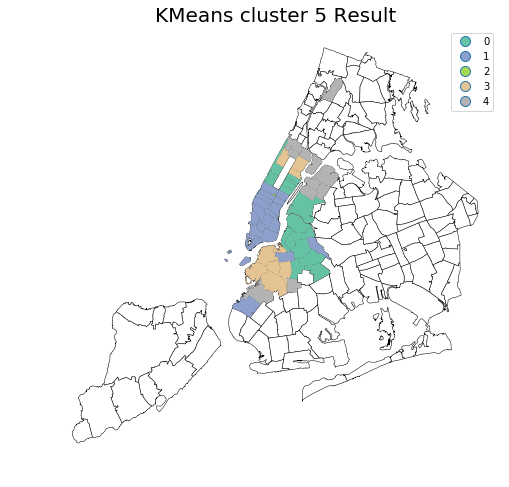

In [9]:
plotting_km_cluster(5)

n_clusters = 5
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
df1['label'] = pd.Series(KM.labels_)
print("Total {} zipcodes".format(len(KM.labels_)))

KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
fig, ax = plt.subplots(figsize=(8,8))
cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans cluster 5 Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [10]:
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
# df1.head()

# FHV

In [11]:
df = pd.read_csv("Transportation_standardize_rmean/fhv_rmean.csv", index_col=0)
# df.head()

In [12]:
df1 = df.T.reset_index()
df1.rename({'index': 'zipcode'}, axis='columns', inplace=True)
df1['zipcode'] = df1['zipcode'].astype('str')
df1.head(2)

zipcode   12/1/15    1/1/16    2/1/16   3/1/16    4/1/16    5/1/16  \
0      83 -0.780956 -0.751937 -0.720572 -0.68487 -0.648531 -0.606311   
1   10001 -1.132774 -1.032869 -0.919792 -0.80903 -0.698910 -0.585962   

     6/1/16    7/1/16    8/1/16    ...       3/1/17    4/1/17    5/1/17  \
0 -0.542279 -0.488660 -0.432053    ...    -0.167781 -0.132588 -0.092654   
1 -0.483130 -0.379116 -0.283082    ...     0.359415  0.434088  0.511217   

     6/1/17    7/1/17    8/1/17    9/1/17  10/1/17   11/1/17   12/1/17  
0  0.050179  0.197997  0.335042  0.471927  0.64007  0.823409  1.034436  
1  0.583157  0.653598  0.726518  0.796333  0.87572  0.959736  1.047608  

[2 rows x 26 columns]

In [13]:
X = df1.iloc[:,1:]
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
# X.head(2)

In [14]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.4564516234110571
For n_clusters = 3, the average silhouette_score is : 0.4403729994890699
For n_clusters = 4, the average silhouette_score is : 0.41701203235893064
For n_clusters = 5, the average silhouette_score is : 0.42850401814366007
For n_clusters = 6, the average silhouette_score is : 0.42896256112315867
For n_clusters = 7, the average silhouette_score is : 0.3695631716710447


In [15]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 26)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

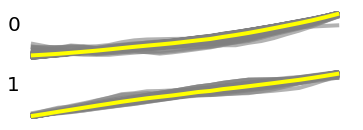

Total 248 zipcodes


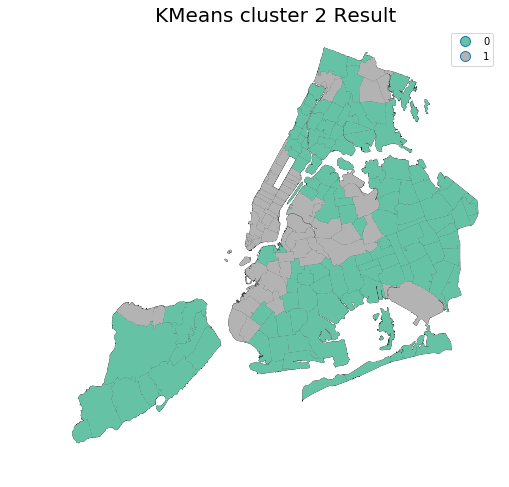

In [16]:
plotting_km_cluster(2)

n_clusters = 2
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
df1['label'] = pd.Series(KM.labels_)
print("Total {} zipcodes".format(len(KM.labels_)))

KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
fig, ax = plt.subplots(figsize=(8,8))
cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans cluster 2 Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [17]:
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
# df1.head()

# Green Taxi

In [18]:
df = pd.read_csv("Transportation_standardize_rmean/gre_rmean.csv", index_col=0)
# df.head()

In [19]:
df1 = df.T.reset_index()
df1.rename({'index': 'zipcode'}, axis='columns', inplace=True)
df1['zipcode'] = df1['zipcode'].astype('str')
df1.head(2)

zipcode    7/1/14    8/1/14    9/1/14   10/1/14   11/1/14   12/1/14  \
0      83 -1.155954 -0.888038 -0.611180 -0.302119 -0.019022  0.288669   
1   10001  0.091226  0.206440  0.218568  0.214526  0.206440  0.192291   

     1/1/15    2/1/15    3/1/15    ...       3/1/17    4/1/17    5/1/17  \
0  0.471931  0.565852  0.623514    ...     0.121742  0.081192  0.056418   
1  0.135695  0.109418  0.085162    ...     0.481338  0.750172  0.752193   

     6/1/17    7/1/17    8/1/17    9/1/17   10/1/17   11/1/17   12/1/17  
0  0.032996  0.007501 -0.001965 -0.016948 -0.015253 -0.019382 -0.045869  
1  0.752193  0.754215  0.738044  0.738044  0.731980  0.740065  0.780492  

[2 rows x 43 columns]

In [20]:
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)

In [21]:
X = df1.iloc[:,1:]
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
# X.head(2)

In [22]:
X.shape

(223, 42)

In [23]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.4452231504984953
For n_clusters = 3, the average silhouette_score is : 0.3787423578437792
For n_clusters = 4, the average silhouette_score is : 0.32895946570877527
For n_clusters = 5, the average silhouette_score is : 0.3372639264331147
For n_clusters = 6, the average silhouette_score is : 0.34995351605906827
For n_clusters = 7, the average silhouette_score is : 0.3633361212715124


In [24]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 43)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

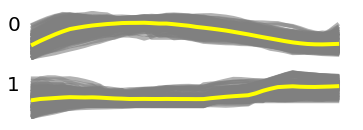

Total 223 zipcodes


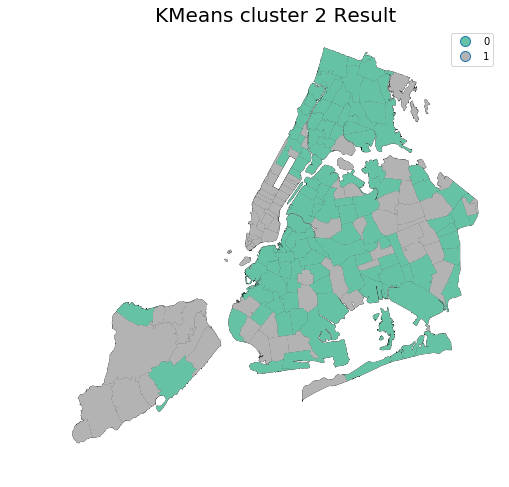

In [25]:
plotting_km_cluster(2)

n_clusters = 2
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
# print(len(KM.labels_))
df1['label'] = pd.Series(KM.labels_)
print("Total {} zipcodes".format(len(KM.labels_)))

KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
fig, ax = plt.subplots(figsize=(8,8))
cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans cluster 2 Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [26]:
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
# df1.head()

# Subway

In [27]:
df = pd.read_csv("Transportation_standardize_rmean/sub_rmean.csv", index_col=0)
# df.head()

In [28]:
df1 = df.T.reset_index()
df1.rename({'index': 'zipcode'}, axis='columns', inplace=True)
df1['zipcode'] = df1['zipcode'].astype('str')
df1.head(2)

zipcode    4/1/11    5/1/11    6/1/11    7/1/11    8/1/11    9/1/11  \
0      83 -0.530484 -0.278583 -0.272437 -0.314724 -0.344341 -0.347415   
1   10001 -0.489479 -0.184090 -0.167443 -0.187564 -0.220727 -0.209381   

    10/1/11   11/1/11   12/1/11    ...       3/1/17    4/1/17    5/1/17  \
0 -0.328011 -0.267811 -0.199118    ...     0.170818  0.108464  0.034801   
1 -0.218722 -0.196386 -0.165043    ...     0.085245  0.028854  0.018642   

     6/1/17    7/1/17    8/1/17    9/1/17   10/1/17   11/1/17   12/1/17  
0 -0.030558 -0.111899 -0.238387 -0.369979 -0.453376 -0.563360 -0.684417  
1 -0.033403 -0.126171 -0.198114 -0.280919 -0.278236 -0.316313 -0.428324  

[2 rows x 82 columns]

In [29]:
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)

In [30]:
X = df1.iloc[:,1:]
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
# X.head(2)

In [31]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.31748791048428504
For n_clusters = 3, the average silhouette_score is : 0.21487692805028888
For n_clusters = 4, the average silhouette_score is : 0.2072813997613713
For n_clusters = 5, the average silhouette_score is : 0.20683354229841103
For n_clusters = 6, the average silhouette_score is : 0.19734719008266197
For n_clusters = 7, the average silhouette_score is : 0.1912915894373048


In [32]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 82)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

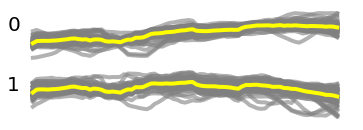

Total 124 zipcodes


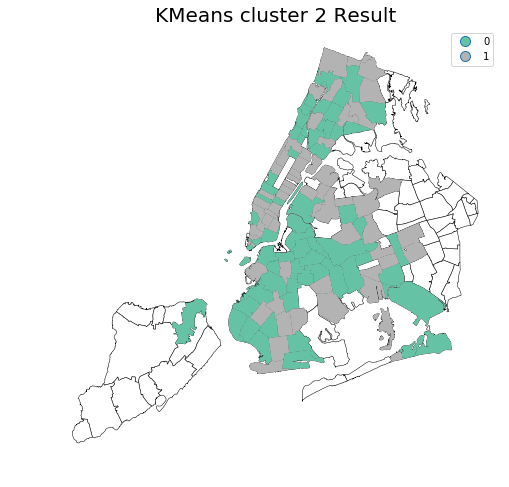

In [33]:
plotting_km_cluster(2)

n_clusters = 2
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
# print(len(KM.labels_))
df1['label'] = pd.Series(KM.labels_)
print("Total {} zipcodes".format(len(KM.labels_)))

KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
fig, ax = plt.subplots(figsize=(8,8))
cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans cluster 2 Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [34]:
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
# df1.head()

# Yellow Taxi

In [35]:
df = pd.read_csv("Transportation_standardize_rmean/yel_rmean.csv", index_col=0)
# df.head(2)

In [36]:
df1 = df.T.reset_index()
df1.rename({'index': 'zipcode'}, axis='columns', inplace=True)
df1['zipcode'] = df1['zipcode'].astype('str')
df1.head(2)

zipcode   12/1/09    1/1/10    2/1/10    3/1/10    4/1/10    5/1/10  \
0      83  0.935078  0.947146  0.986318  1.045140  1.039516  1.050875   
1   10001  0.486155  0.527743  0.583847  0.580765  0.595247  0.618836   

     6/1/10    7/1/10    8/1/10    ...       3/1/17    4/1/17    5/1/17  \
0  1.063008  1.073866  0.994083    ...    -1.524334 -1.564123 -1.615721   
1  0.641250  0.686405  0.616370    ...    -1.548810 -1.640475 -1.747420   

     6/1/17    7/1/17    8/1/17    9/1/17   10/1/17   11/1/17   12/1/17  
0 -1.660521 -1.640255 -1.653402 -1.645406 -1.627944 -1.594259 -1.543363  
1 -1.840084 -1.863267 -1.902611 -1.906563 -1.912251 -1.918623 -1.930449  

[2 rows x 98 columns]

In [37]:
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)

In [38]:
X = df1.iloc[:,1:]
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
# X.head(2)

In [39]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.31507006268624527
For n_clusters = 3, the average silhouette_score is : 0.343645889068683
For n_clusters = 4, the average silhouette_score is : 0.3656182710999523
For n_clusters = 5, the average silhouette_score is : 0.32742032648690717
For n_clusters = 6, the average silhouette_score is : 0.3409502098456071
For n_clusters = 7, the average silhouette_score is : 0.28996046542419945


In [40]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 98)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

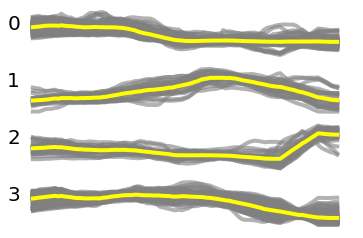

Total 248 zipcodes


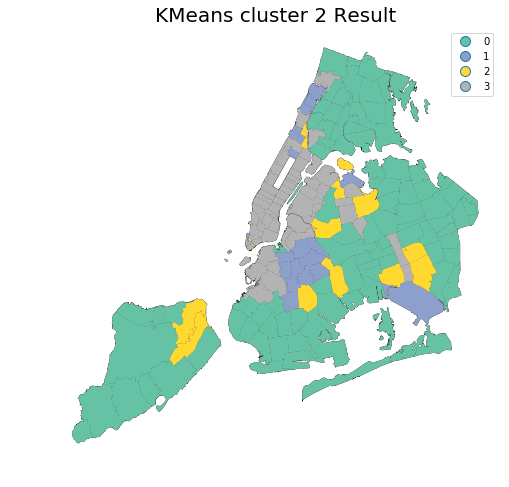

In [41]:
plotting_km_cluster(4)

n_clusters = 4
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
# print(len(KM.labels_))
df1['label'] = pd.Series(KM.labels_)
print("Total {} zipcodes".format(len(KM.labels_)))

KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
fig, ax = plt.subplots(figsize=(8,8))
cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans cluster 2 Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [42]:
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
# df1.head()

# 311 complaints

In [43]:
namelist = ['Street_Condition',
 'PLUMBING',
 'Street_Light_Condition',
 'Noise_Residential',
 'Traffic_Signal_Condition',
 'General_Construction_Plumbing',
 'Blocked_Driveway',
 'ELECTRIC',
 'Damaged_Tree',
 'Building_Use',
 'Graffiti',
 'Taxi_Complaint',
 'Noise_Commercial',
 'Rodent',
 'SCRIE',
 'Sidewalk_Condition',
 'Derelict_Vehicle',
 'DOF_Property_Owner_Issue',
 'APPLIANCE',
 'Noise_Street_Sidewalk']

In [44]:
def find_best_cluster(X):
    best_cluster, best_score = 1, 0
    for n_clusters in range_n_clusters:
        km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
        cluster_labels = km.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters = {}, the average silhouette_score is : {}".format(
            n_clusters, silhouette_avg))
        if silhouette_avg > best_score:
            best_cluster = n_clusters
            best_score = silhouette_avg
    print(">> Best cluster is n_clusters = {}, the average silhouette_score is : {}".format(best_cluster, best_score))
    return best_cluster, best_score

In [45]:
def plotting_km_cluster(n_clusters, timespan):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, timespan)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

In [46]:
def plot_result(best_cluster, timespan):
    plotting_km_cluster(best_cluster, timespan)

    n_clusters = best_cluster
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    print("Total {} zipcodes".format(len(KM.labels_)))
    df1['label'] = pd.Series(KM.labels_)

    KMmap = gpd.GeoDataFrame(pd.merge(nyc, df1, on='zipcode', how='inner'))
    fig, ax = plt.subplots(figsize=(8,8))
    cp.choroplethNYC(nyc, 
                 column=None, color="white", edgecolor="black", lw=0.5, ax=ax)
    KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
    ax.set_title('KMeans cluster ' + str(n_clusters) + ' Result', fontsize=20)
    ax.set_axis_off()
    plt.show()

----- Street_Condition -----
For n_clusters = 2, the average silhouette_score is : 0.26748392405119004
For n_clusters = 3, the average silhouette_score is : 0.25047527836114747
For n_clusters = 4, the average silhouette_score is : 0.2186955934825345
For n_clusters = 5, the average silhouette_score is : 0.1862144646876326
For n_clusters = 6, the average silhouette_score is : 0.1825130219866034
For n_clusters = 7, the average silhouette_score is : 0.17509543430566785
For n_clusters = 8, the average silhouette_score is : 0.15950309522997663
For n_clusters = 9, the average silhouette_score is : 0.16096083808369294
For n_clusters = 10, the average silhouette_score is : 0.14374580399388448
For n_clusters = 11, the average silhouette_score is : 0.161748647567586
For n_clusters = 12, the average silhouette_score is : 0.16278697208610424
For n_clusters = 13, the average silhouette_score is : 0.1558052327257263
For n_clusters = 14, the average silhouette_score is : 0.1579959056439003
For n_clust

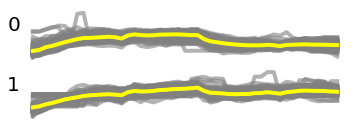

Total 180 zipcodes


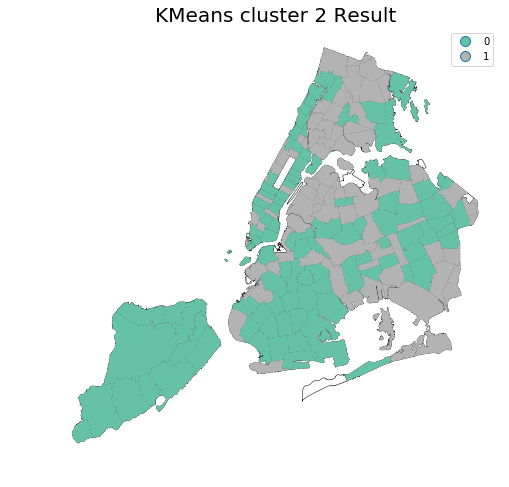

-------------------------------------------------------------------------
----- PLUMBING -----
For n_clusters = 2, the average silhouette_score is : 0.39282893457936596
For n_clusters = 3, the average silhouette_score is : 0.2174289345223095
For n_clusters = 4, the average silhouette_score is : 0.19012791688029793
For n_clusters = 5, the average silhouette_score is : 0.1650091487999403
For n_clusters = 6, the average silhouette_score is : 0.18437115239738253
For n_clusters = 7, the average silhouette_score is : 0.19640809496957384
For n_clusters = 8, the average silhouette_score is : 0.2085394959728416
For n_clusters = 9, the average silhouette_score is : 0.1910399950095068
For n_clusters = 10, the average silhouette_score is : 0.15321856995759342
For n_clusters = 11, the average silhouette_score is : 0.15521238410309735
For n_clusters = 12, the average silhouette_score is : 0.14625918029468923
For n_clusters = 13, the average silhouette_score is : 0.18351231200000317
For n_clusters = 

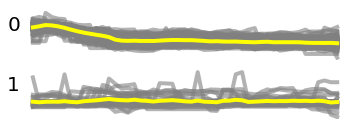

Total 159 zipcodes


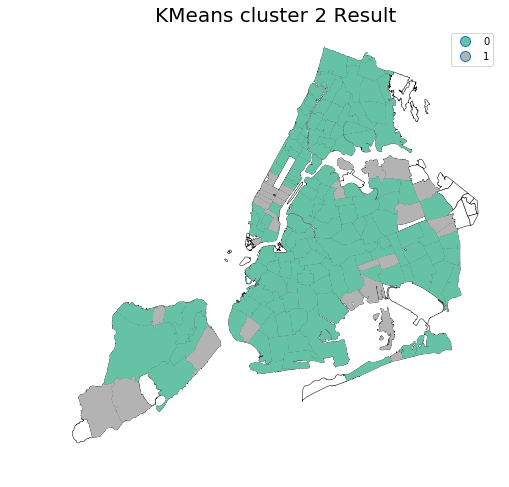

-------------------------------------------------------------------------
----- Street_Light_Condition -----
For n_clusters = 2, the average silhouette_score is : 0.24825171620120015
For n_clusters = 3, the average silhouette_score is : 0.18135662990954893
For n_clusters = 4, the average silhouette_score is : 0.17601378947448434
For n_clusters = 5, the average silhouette_score is : 0.1906548648427618
For n_clusters = 6, the average silhouette_score is : 0.18566046311380022
For n_clusters = 7, the average silhouette_score is : 0.1782364060840839
For n_clusters = 8, the average silhouette_score is : 0.15543113740138226
For n_clusters = 9, the average silhouette_score is : 0.15043591841379994
For n_clusters = 10, the average silhouette_score is : 0.15933127411911982
For n_clusters = 11, the average silhouette_score is : 0.17016569991577576
For n_clusters = 12, the average silhouette_score is : 0.16731498118676733
For n_clusters = 13, the average silhouette_score is : 0.16874260559499576
F

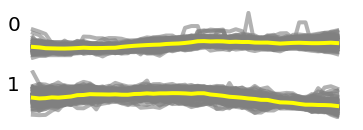

Total 164 zipcodes


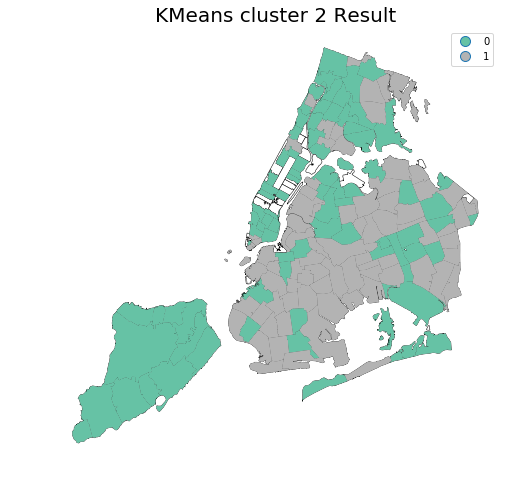

-------------------------------------------------------------------------
----- Noise_Residential -----
For n_clusters = 2, the average silhouette_score is : 0.27067503803150944
For n_clusters = 3, the average silhouette_score is : 0.18403448659273244
For n_clusters = 4, the average silhouette_score is : 0.21304370181322382
For n_clusters = 5, the average silhouette_score is : 0.18264151607878854
For n_clusters = 6, the average silhouette_score is : 0.16666206569297556
For n_clusters = 7, the average silhouette_score is : 0.1670389672205097
For n_clusters = 8, the average silhouette_score is : 0.17824702104113022
For n_clusters = 9, the average silhouette_score is : 0.1768286323144235
For n_clusters = 10, the average silhouette_score is : 0.17657155051943513
For n_clusters = 11, the average silhouette_score is : 0.17455857056063676
For n_clusters = 12, the average silhouette_score is : 0.17066304143498431
For n_clusters = 13, the average silhouette_score is : 0.17890169735541472
For n_

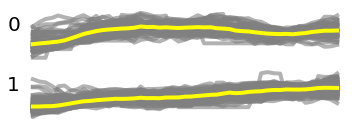

Total 176 zipcodes


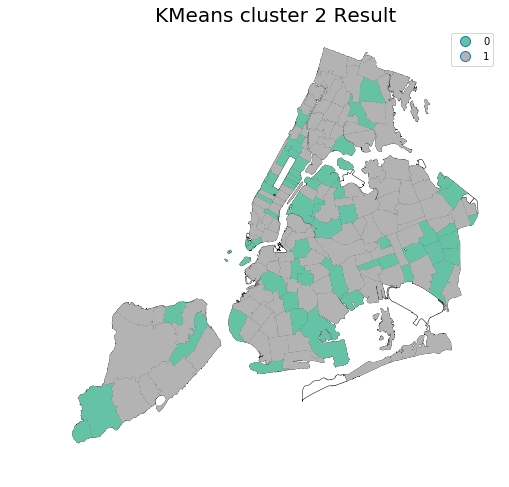

-------------------------------------------------------------------------
----- Traffic_Signal_Condition -----
For n_clusters = 2, the average silhouette_score is : 0.284517026354422
For n_clusters = 3, the average silhouette_score is : 0.23572131710267433
For n_clusters = 4, the average silhouette_score is : 0.23140721671005154
For n_clusters = 5, the average silhouette_score is : 0.19609539129099357
For n_clusters = 6, the average silhouette_score is : 0.19647669627829778
For n_clusters = 7, the average silhouette_score is : 0.1858257909246929
For n_clusters = 8, the average silhouette_score is : 0.1661491553346227
For n_clusters = 9, the average silhouette_score is : 0.1671277395904478
For n_clusters = 10, the average silhouette_score is : 0.19340549756049086
For n_clusters = 11, the average silhouette_score is : 0.18781730295418506
For n_clusters = 12, the average silhouette_score is : 0.18009383990912403
For n_clusters = 13, the average silhouette_score is : 0.17422670708118426
Fo

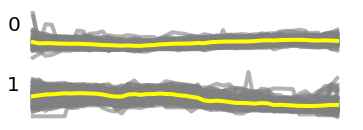

Total 144 zipcodes


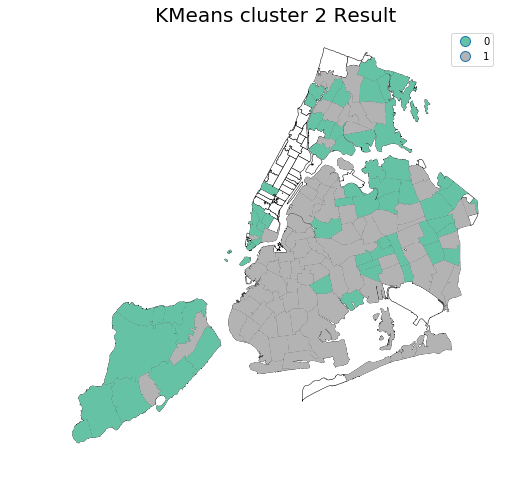

-------------------------------------------------------------------------
----- General_Construction_Plumbing -----
For n_clusters = 2, the average silhouette_score is : 0.24471914133830291
For n_clusters = 3, the average silhouette_score is : 0.21768473690085824
For n_clusters = 4, the average silhouette_score is : 0.16361378278458488
For n_clusters = 5, the average silhouette_score is : 0.16441203004424115
For n_clusters = 6, the average silhouette_score is : 0.1617817276037453
For n_clusters = 7, the average silhouette_score is : 0.1483270471727498
For n_clusters = 8, the average silhouette_score is : 0.13411017474042278
For n_clusters = 9, the average silhouette_score is : 0.13487823260307477
For n_clusters = 10, the average silhouette_score is : 0.1283330999758984
For n_clusters = 11, the average silhouette_score is : 0.1330572894795807
For n_clusters = 12, the average silhouette_score is : 0.12875705980543384
For n_clusters = 13, the average silhouette_score is : 0.12948393286418

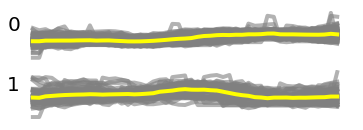

Total 171 zipcodes


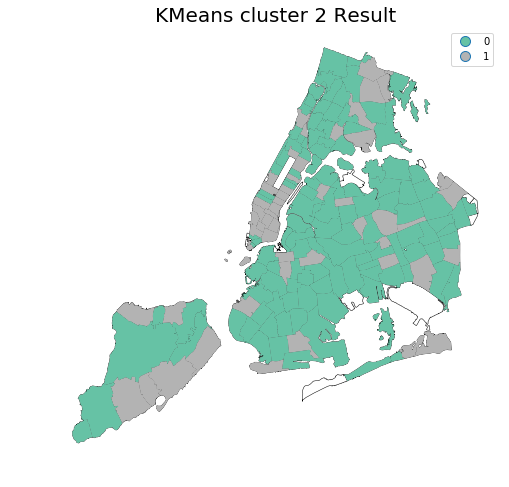

-------------------------------------------------------------------------
----- Blocked_Driveway -----
For n_clusters = 2, the average silhouette_score is : 0.5385863529314306
For n_clusters = 3, the average silhouette_score is : 0.5298018625459907
For n_clusters = 4, the average silhouette_score is : 0.5316775870158875
For n_clusters = 5, the average silhouette_score is : 0.20008636487452627
For n_clusters = 6, the average silhouette_score is : 0.25817854728762957
For n_clusters = 7, the average silhouette_score is : 0.23507255044351344
For n_clusters = 8, the average silhouette_score is : 0.23237598542493962
For n_clusters = 9, the average silhouette_score is : 0.23125530584428647
For n_clusters = 10, the average silhouette_score is : 0.21839524695478565
For n_clusters = 11, the average silhouette_score is : 0.23678535417916705
For n_clusters = 12, the average silhouette_score is : 0.21830162807932368
For n_clusters = 13, the average silhouette_score is : 0.2547733776995164
For n_clu

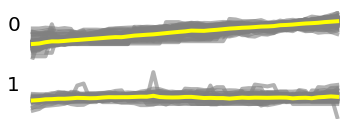

Total 171 zipcodes


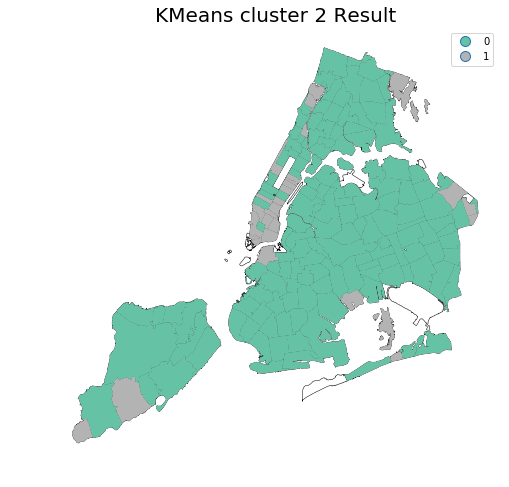

-------------------------------------------------------------------------
----- ELECTRIC -----
For n_clusters = 2, the average silhouette_score is : 0.21548098853778114
For n_clusters = 3, the average silhouette_score is : 0.18287673469688645
For n_clusters = 4, the average silhouette_score is : 0.19234416985175587
For n_clusters = 5, the average silhouette_score is : 0.16910865205551714
For n_clusters = 6, the average silhouette_score is : 0.16850727324276504
For n_clusters = 7, the average silhouette_score is : 0.1580597571472129
For n_clusters = 8, the average silhouette_score is : 0.17261096302403883
For n_clusters = 9, the average silhouette_score is : 0.15317588340134455
For n_clusters = 10, the average silhouette_score is : 0.1599939952820335
For n_clusters = 11, the average silhouette_score is : 0.17344621330613616
For n_clusters = 12, the average silhouette_score is : 0.17494437458178896
For n_clusters = 13, the average silhouette_score is : 0.1660054927383071
For n_clusters =

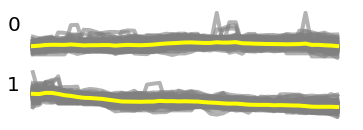

Total 152 zipcodes


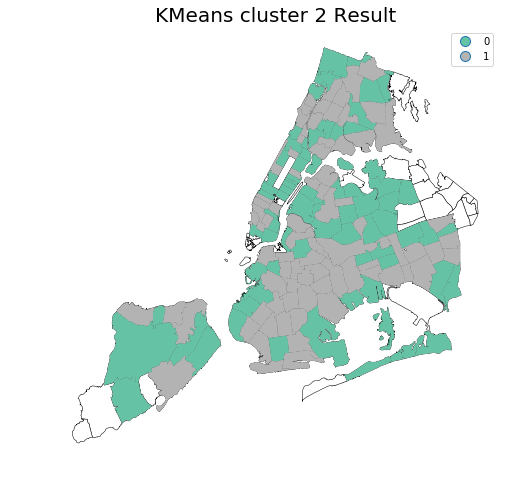

-------------------------------------------------------------------------
----- Damaged_Tree -----
For n_clusters = 2, the average silhouette_score is : 0.21846709214650395
For n_clusters = 3, the average silhouette_score is : 0.2379867438212012
For n_clusters = 4, the average silhouette_score is : 0.22502189752724802
For n_clusters = 5, the average silhouette_score is : 0.2127612334720612
For n_clusters = 6, the average silhouette_score is : 0.19576198898264235
For n_clusters = 7, the average silhouette_score is : 0.21872535816126154
For n_clusters = 8, the average silhouette_score is : 0.1966722908203464
For n_clusters = 9, the average silhouette_score is : 0.22653777192798955
For n_clusters = 10, the average silhouette_score is : 0.23589598484015797
For n_clusters = 11, the average silhouette_score is : 0.2555199671967065
For n_clusters = 12, the average silhouette_score is : 0.22271227241695282
For n_clusters = 13, the average silhouette_score is : 0.22490042959471587
For n_cluster

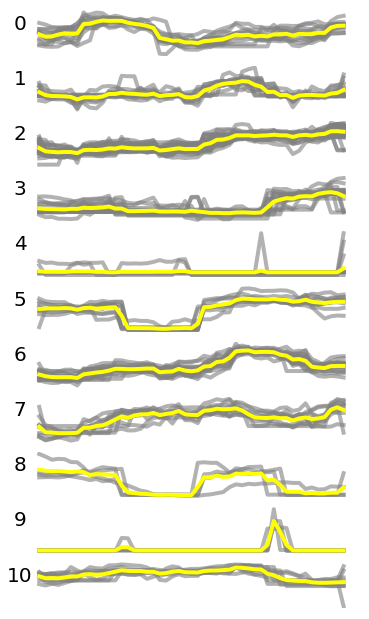

Total 159 zipcodes


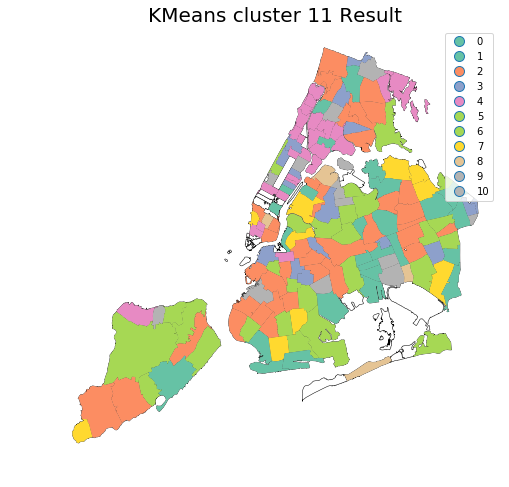

-------------------------------------------------------------------------
----- Building_Use -----
For n_clusters = 2, the average silhouette_score is : 0.24685835133538342
For n_clusters = 3, the average silhouette_score is : 0.17073349319135533
For n_clusters = 4, the average silhouette_score is : 0.15231452553860644
For n_clusters = 5, the average silhouette_score is : 0.14547422713373173
For n_clusters = 6, the average silhouette_score is : 0.15485315034724928
For n_clusters = 7, the average silhouette_score is : 0.16758786050566074
For n_clusters = 8, the average silhouette_score is : 0.16418109883246262
For n_clusters = 9, the average silhouette_score is : 0.1648519266854758
For n_clusters = 10, the average silhouette_score is : 0.16633084280165
For n_clusters = 11, the average silhouette_score is : 0.147339280948002
For n_clusters = 12, the average silhouette_score is : 0.14190546926726125
For n_clusters = 13, the average silhouette_score is : 0.14914544006548763
For n_clusters 

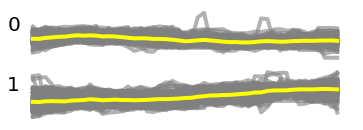

Total 168 zipcodes


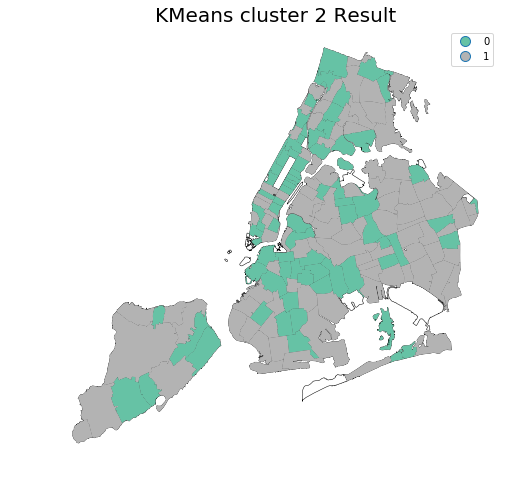

-------------------------------------------------------------------------
----- Graffiti -----
For n_clusters = 2, the average silhouette_score is : 0.22505435510501098
For n_clusters = 3, the average silhouette_score is : 0.22460458648762277
For n_clusters = 4, the average silhouette_score is : 0.23197165160284097
For n_clusters = 5, the average silhouette_score is : 0.24421617932028727
For n_clusters = 6, the average silhouette_score is : 0.26124418622211965
For n_clusters = 7, the average silhouette_score is : 0.26283522561062705
For n_clusters = 8, the average silhouette_score is : 0.2671444289535689
For n_clusters = 9, the average silhouette_score is : 0.2819443373899021
For n_clusters = 10, the average silhouette_score is : 0.27517082413321003
For n_clusters = 11, the average silhouette_score is : 0.2856071311018104
For n_clusters = 12, the average silhouette_score is : 0.28479584637063243
For n_clusters = 13, the average silhouette_score is : 0.2815281944452831
For n_clusters = 

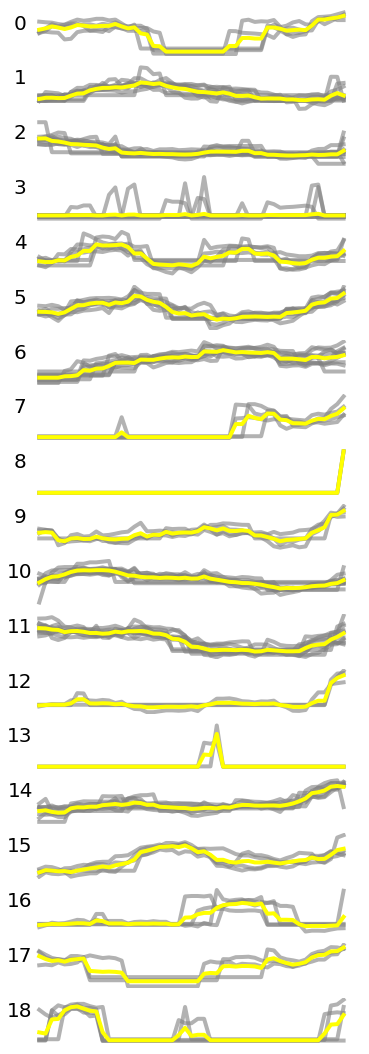

Total 142 zipcodes


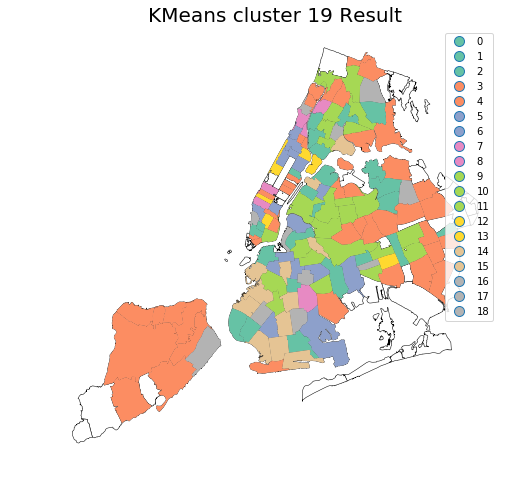

-------------------------------------------------------------------------
----- Taxi_Complaint -----
For n_clusters = 2, the average silhouette_score is : 0.23722356404334116
For n_clusters = 3, the average silhouette_score is : 0.28913938604703343
For n_clusters = 4, the average silhouette_score is : 0.2903071879268643
For n_clusters = 5, the average silhouette_score is : 0.2894227178765277
For n_clusters = 6, the average silhouette_score is : 0.3076638902027004
For n_clusters = 7, the average silhouette_score is : 0.27242318877910804
For n_clusters = 8, the average silhouette_score is : 0.2810372635856489
For n_clusters = 9, the average silhouette_score is : 0.28404928610709645
For n_clusters = 10, the average silhouette_score is : 0.2950581930621524
For n_clusters = 11, the average silhouette_score is : 0.299388875235303
For n_clusters = 12, the average silhouette_score is : 0.31281613846296313
For n_clusters = 13, the average silhouette_score is : 0.2739170210667236
For n_clusters 

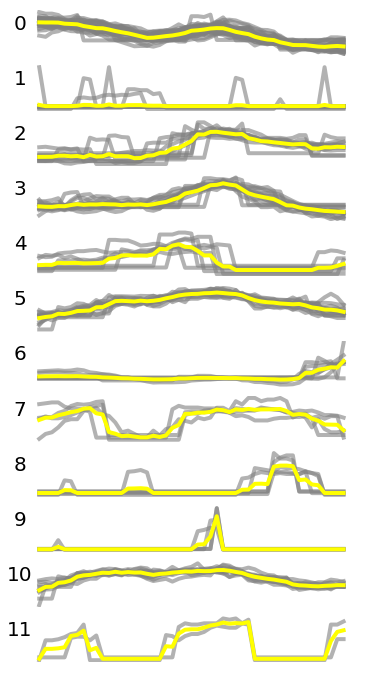

Total 136 zipcodes


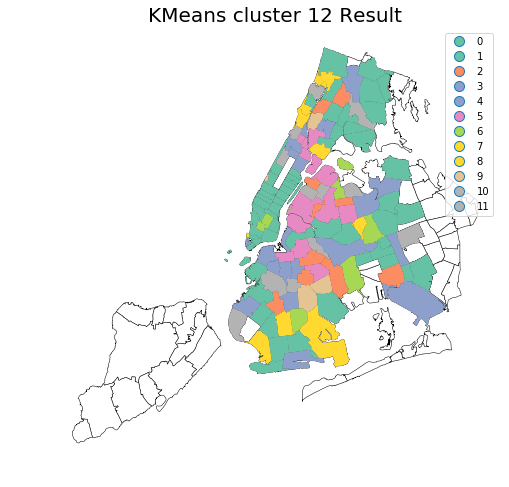

-------------------------------------------------------------------------
----- Noise_Commercial -----
For n_clusters = 2, the average silhouette_score is : 0.26308521922070977
For n_clusters = 3, the average silhouette_score is : 0.22875083041257974
For n_clusters = 4, the average silhouette_score is : 0.19803469647966612
For n_clusters = 5, the average silhouette_score is : 0.2121028340062861
For n_clusters = 6, the average silhouette_score is : 0.19652856606483313
For n_clusters = 7, the average silhouette_score is : 0.1895845059656254
For n_clusters = 8, the average silhouette_score is : 0.1882528060362919
For n_clusters = 9, the average silhouette_score is : 0.18939960821139754
For n_clusters = 10, the average silhouette_score is : 0.19270593301784306
For n_clusters = 11, the average silhouette_score is : 0.17407937764100637
For n_clusters = 12, the average silhouette_score is : 0.19387969864859392
For n_clusters = 13, the average silhouette_score is : 0.17498395999914948
For n_cl

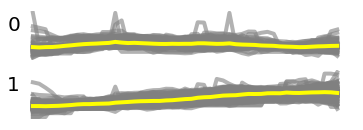

Total 158 zipcodes


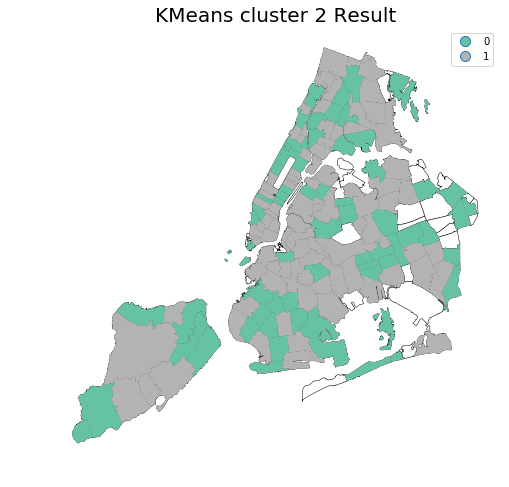

-------------------------------------------------------------------------
----- Rodent -----
For n_clusters = 2, the average silhouette_score is : 0.2952250675749937
For n_clusters = 3, the average silhouette_score is : 0.18994112003796362
For n_clusters = 4, the average silhouette_score is : 0.17923448869059785
For n_clusters = 5, the average silhouette_score is : 0.17910263839383445
For n_clusters = 6, the average silhouette_score is : 0.18363343304496446
For n_clusters = 7, the average silhouette_score is : 0.13994165823137783
For n_clusters = 8, the average silhouette_score is : 0.14424699791076115
For n_clusters = 9, the average silhouette_score is : 0.17877808361641545
For n_clusters = 10, the average silhouette_score is : 0.16780403444022074
For n_clusters = 11, the average silhouette_score is : 0.17339736978591583
For n_clusters = 12, the average silhouette_score is : 0.14969997383692743
For n_clusters = 13, the average silhouette_score is : 0.13750656173670744
For n_clusters =

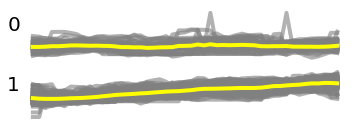

Total 166 zipcodes


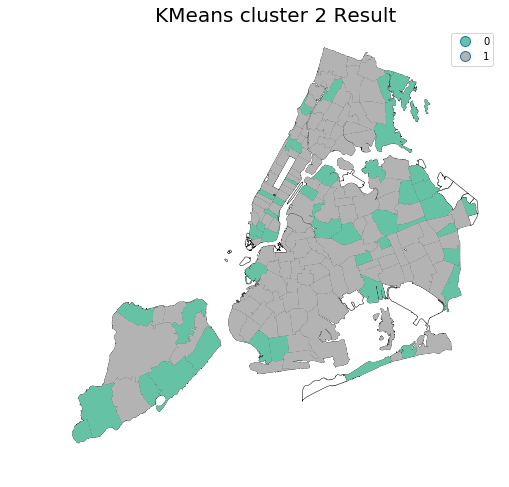

-------------------------------------------------------------------------
----- SCRIE -----
For n_clusters = 2, the average silhouette_score is : 0.22756238882236504
For n_clusters = 3, the average silhouette_score is : 0.24202196763908623
For n_clusters = 4, the average silhouette_score is : 0.2492196190163412
For n_clusters = 5, the average silhouette_score is : 0.2648534112188859
For n_clusters = 6, the average silhouette_score is : 0.1947010165102165
For n_clusters = 7, the average silhouette_score is : 0.21254067986570632
For n_clusters = 8, the average silhouette_score is : 0.2001587228352132
For n_clusters = 9, the average silhouette_score is : 0.2237250069639415
For n_clusters = 10, the average silhouette_score is : 0.23082433313583564
For n_clusters = 11, the average silhouette_score is : 0.22226069009723406
For n_clusters = 12, the average silhouette_score is : 0.21821553046436318
For n_clusters = 13, the average silhouette_score is : 0.23805839245823243
For n_clusters = 14, 

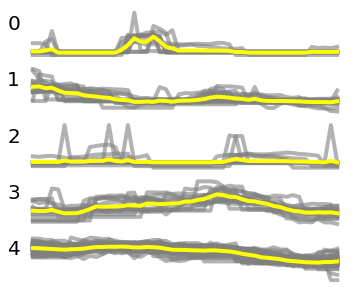

Total 123 zipcodes


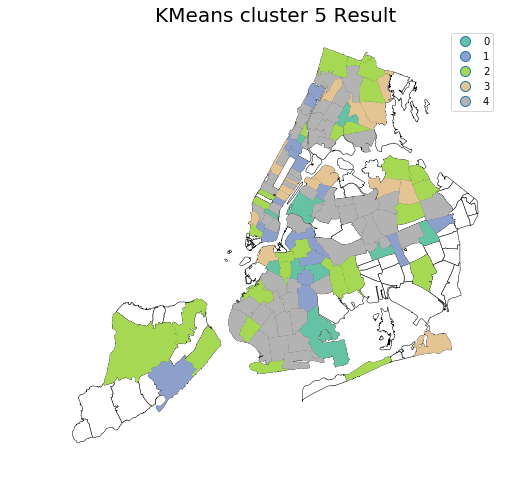

-------------------------------------------------------------------------
----- Sidewalk_Condition -----
For n_clusters = 2, the average silhouette_score is : 0.19254555190695344
For n_clusters = 3, the average silhouette_score is : 0.17445543134362598
For n_clusters = 4, the average silhouette_score is : 0.17751030031223136
For n_clusters = 5, the average silhouette_score is : 0.16067947643086372
For n_clusters = 6, the average silhouette_score is : 0.18616977783046945
For n_clusters = 7, the average silhouette_score is : 0.1581188011786726
For n_clusters = 8, the average silhouette_score is : 0.15988320561862646
For n_clusters = 9, the average silhouette_score is : 0.13965070431376275
For n_clusters = 10, the average silhouette_score is : 0.1390754634638111
For n_clusters = 11, the average silhouette_score is : 0.15684729778425519
For n_clusters = 12, the average silhouette_score is : 0.1384887076015277
For n_clusters = 13, the average silhouette_score is : 0.1414283285058118
For n_c

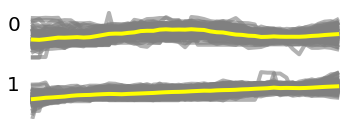

Total 173 zipcodes


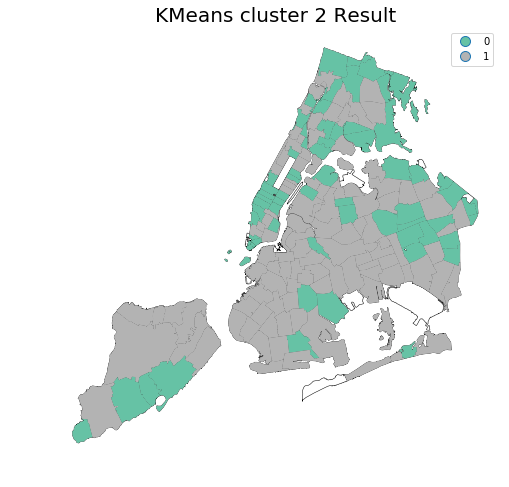

-------------------------------------------------------------------------
----- Derelict_Vehicle -----
For n_clusters = 2, the average silhouette_score is : 0.46578217144250034
For n_clusters = 3, the average silhouette_score is : 0.3218497096715399
For n_clusters = 4, the average silhouette_score is : 0.26950254033546733
For n_clusters = 5, the average silhouette_score is : 0.2790594836677325
For n_clusters = 6, the average silhouette_score is : 0.22544475595451258
For n_clusters = 7, the average silhouette_score is : 0.23684050709436263
For n_clusters = 8, the average silhouette_score is : 0.311695726028432
For n_clusters = 9, the average silhouette_score is : 0.25696469550430606
For n_clusters = 10, the average silhouette_score is : 0.2790521673516166
For n_clusters = 11, the average silhouette_score is : 0.2510361321165931
For n_clusters = 12, the average silhouette_score is : 0.26398355978920063
For n_clusters = 13, the average silhouette_score is : 0.2681129948165587
For n_cluste

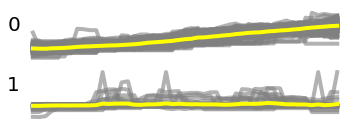

Total 158 zipcodes


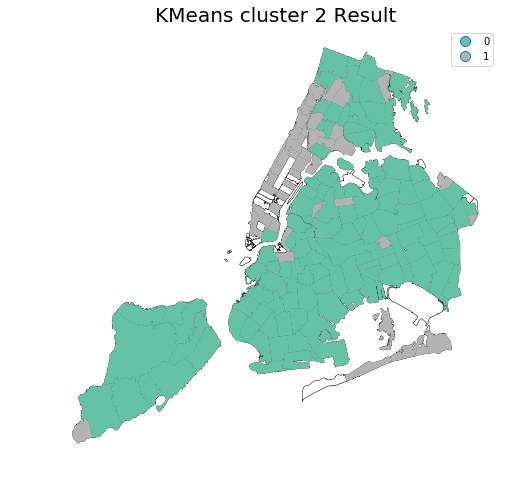

-------------------------------------------------------------------------
----- DOF_Property_Owner_Issue -----
For n_clusters = 2, the average silhouette_score is : 0.30154644309770345
For n_clusters = 3, the average silhouette_score is : 0.2953656892568996
For n_clusters = 4, the average silhouette_score is : 0.32087327550665384
For n_clusters = 5, the average silhouette_score is : 0.32686418547838153
For n_clusters = 6, the average silhouette_score is : 0.3223946524856703
For n_clusters = 7, the average silhouette_score is : 0.35225094170733406
For n_clusters = 8, the average silhouette_score is : 0.2625592946592182
For n_clusters = 9, the average silhouette_score is : 0.2698133594846188
For n_clusters = 10, the average silhouette_score is : 0.27259357184189187
For n_clusters = 11, the average silhouette_score is : 0.2923472145623718
For n_clusters = 12, the average silhouette_score is : 0.29273704319439
For n_clusters = 13, the average silhouette_score is : 0.3021403379616696
For n_

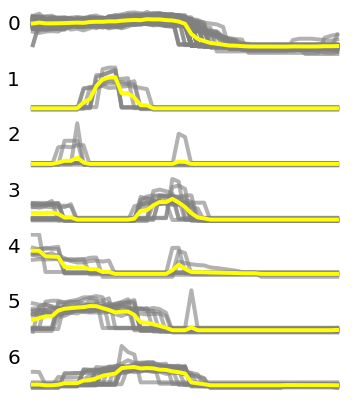

Total 137 zipcodes


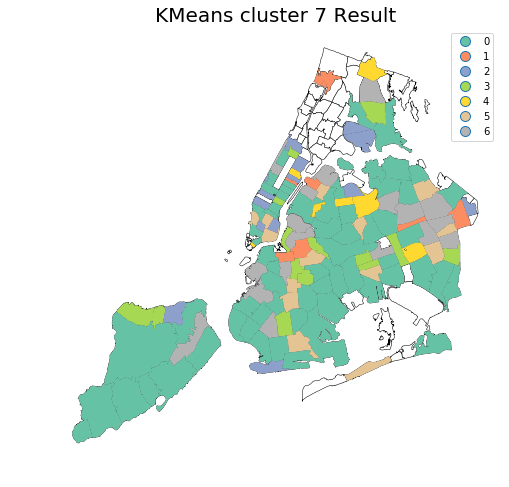

-------------------------------------------------------------------------
----- APPLIANCE -----
For n_clusters = 2, the average silhouette_score is : 0.2546419828033808
For n_clusters = 3, the average silhouette_score is : 0.2546950479292918
For n_clusters = 4, the average silhouette_score is : 0.2547271614238996
For n_clusters = 5, the average silhouette_score is : 0.2552923545683327
For n_clusters = 6, the average silhouette_score is : 0.27090213209736563
For n_clusters = 7, the average silhouette_score is : 0.2322945301570911
For n_clusters = 8, the average silhouette_score is : 0.22360086692853864
For n_clusters = 9, the average silhouette_score is : 0.2490361971632962
For n_clusters = 10, the average silhouette_score is : 0.24301616946192478
For n_clusters = 11, the average silhouette_score is : 0.2398981034883768
For n_clusters = 12, the average silhouette_score is : 0.25257060626869904
For n_clusters = 13, the average silhouette_score is : 0.25485699487923485
For n_clusters = 14

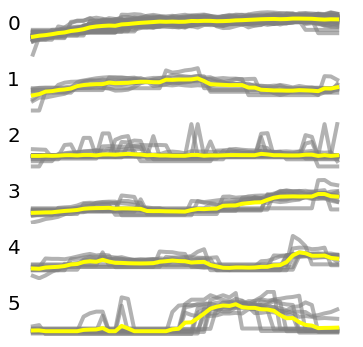

Total 124 zipcodes


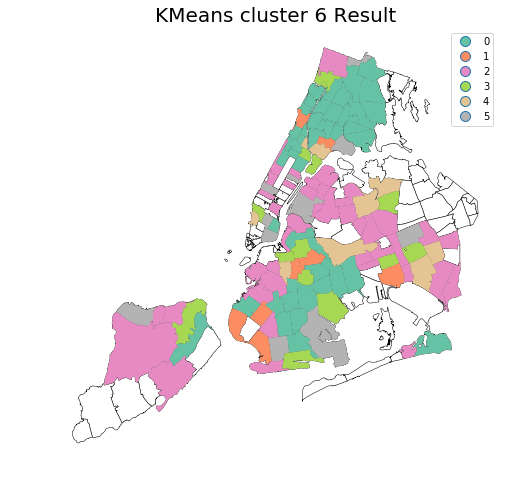

-------------------------------------------------------------------------
----- Noise_Street_Sidewalk -----
For n_clusters = 2, the average silhouette_score is : 0.35288570231982685
For n_clusters = 3, the average silhouette_score is : 0.20636546924608382
For n_clusters = 4, the average silhouette_score is : 0.2351810727699557
For n_clusters = 5, the average silhouette_score is : 0.24195366733092927
For n_clusters = 6, the average silhouette_score is : 0.26833262408487213
For n_clusters = 7, the average silhouette_score is : 0.2779442899958299
For n_clusters = 8, the average silhouette_score is : 0.25259654349519833
For n_clusters = 9, the average silhouette_score is : 0.25753689223165166
For n_clusters = 10, the average silhouette_score is : 0.272252346173056
For n_clusters = 11, the average silhouette_score is : 0.24148993895690007
For n_clusters = 12, the average silhouette_score is : 0.25284046480954
For n_clusters = 13, the average silhouette_score is : 0.23617904139973603
For n_c

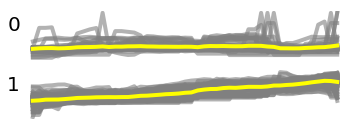

Total 167 zipcodes


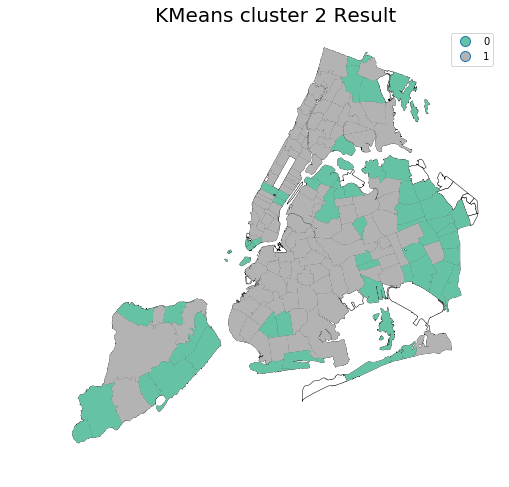

-------------------------------------------------------------------------


In [66]:
for i in range(20):
    df = pd.read_csv("complaint/" + namelist[i] + ".csv", index_col=0)
    print("----- " + namelist[i] + " -----")
    df1 = df
    df1['zipcode'] = df1['zipcode'].astype('str')
    df1.dropna(inplace=True)
    df1.reset_index(drop=True, inplace=True)
    X = df1.iloc[:,1:]
    mean = X.mean(axis=1)
    std = X.std(axis=1)
    X = X.apply(lambda x: (x - mean) / std)
    range_n_clusters = range(2,20)
    X.reset_index(drop=True, inplace=True)
    X.fillna(0, inplace=True)
    
    best_cluster = find_best_cluster(X)[0]
    
    timespan = df1.shape[1]
    plot_result(best_cluster, timespan)
    
    df1.drop(df1.columns[1:-1], axis=1, inplace=True)
    df1.to_csv("cluster" + namelist[i] + ".csv")
    print("-------------------------------------------------------------------------")

# masterCard

----- MasterCard -----
For n_clusters = 2, the average silhouette_score is : 0.2524940903490621
For n_clusters = 3, the average silhouette_score is : 0.25053239872397676
For n_clusters = 4, the average silhouette_score is : 0.2258342217758181
For n_clusters = 5, the average silhouette_score is : 0.22385495343872233
For n_clusters = 6, the average silhouette_score is : 0.21736393326624484
For n_clusters = 7, the average silhouette_score is : 0.19299764456613336
>> Best cluster is n_clusters = 2, the average silhouette_score is : 0.2524940903490621


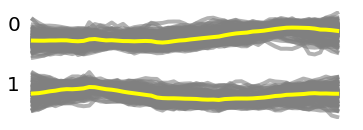

Total 197 zipcodes


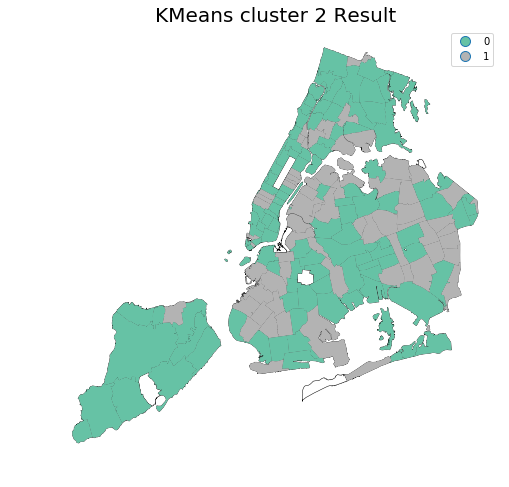

-------------------------------------------------------------------------


In [48]:
df = pd.read_csv("mastercard/masterCard_rmean.csv", index_col=0)
print("----- MasterCard -----")
df1 = df
df1['zipcode'] = df1['zipcode'].astype('str')
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)
X = df1.iloc[:,1:]
mean = X.mean(axis=1)
std = X.std(axis=1)
X = X.apply(lambda x: (x - mean) / std)
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
    
best_cluster = find_best_cluster(X)[0]

timespan = df1.shape[1]
plot_result(best_cluster, timespan)
    
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
df1.to_csv("clusterMasterCard.csv")
print("-------------------------------------------------------------------------")

# Crime

----- Drugs -----
For n_clusters = 2, the average silhouette_score is : 0.6511597003469305
For n_clusters = 3, the average silhouette_score is : 0.5673122824541271
For n_clusters = 4, the average silhouette_score is : 0.6001860270811675
For n_clusters = 5, the average silhouette_score is : 0.5761627006837126
For n_clusters = 6, the average silhouette_score is : 0.564415222156536
For n_clusters = 7, the average silhouette_score is : 0.5731040350484645
>> Best cluster is n_clusters = 2, the average silhouette_score is : 0.6511597003469305


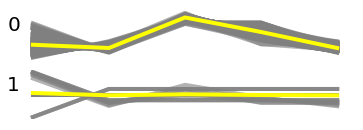

Total 248 zipcodes


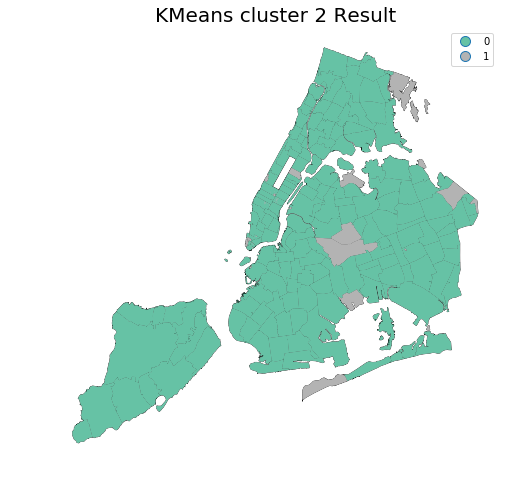

-------------------------------------------------------------------------


In [58]:
df = pd.read_csv("yearlydata/drugs.csv")
print("----- Drugs -----")
df1 = df
df1['zipcode'] = df1['zipcode'].astype('str')
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)
X = df1.iloc[:,1:]
mean = X.mean(axis=1)
std = X.std(axis=1)
# print(std)
X = X.apply(lambda x: (x - mean) / std)
# print(X)
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
X.fillna(0, inplace=True)
    
best_cluster = find_best_cluster(X)[0]

timespan = df1.shape[1]
plot_result(best_cluster, timespan)
    
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
df1.to_csv("cluster_drugs.csv")
print("-------------------------------------------------------------------------")

----- petit_larceny -----
For n_clusters = 2, the average silhouette_score is : 0.29442140477177653
For n_clusters = 3, the average silhouette_score is : 0.28975521029954227
For n_clusters = 4, the average silhouette_score is : 0.29440850602700946
For n_clusters = 5, the average silhouette_score is : 0.31792841389117915
For n_clusters = 6, the average silhouette_score is : 0.3392478653630434
For n_clusters = 7, the average silhouette_score is : 0.36941334261930725
For n_clusters = 8, the average silhouette_score is : 0.3842097744616944
For n_clusters = 9, the average silhouette_score is : 0.4003587631162838
For n_clusters = 10, the average silhouette_score is : 0.4041809612203371
For n_clusters = 11, the average silhouette_score is : 0.4241527369487704
For n_clusters = 12, the average silhouette_score is : 0.4174025758083289
For n_clusters = 13, the average silhouette_score is : 0.4222670540998426
For n_clusters = 14, the average silhouette_score is : 0.4228495514363189
For n_clusters 

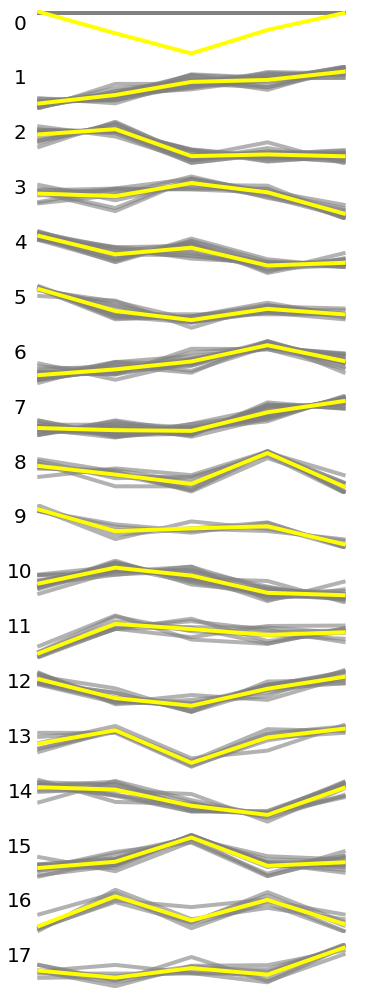

Total 248 zipcodes


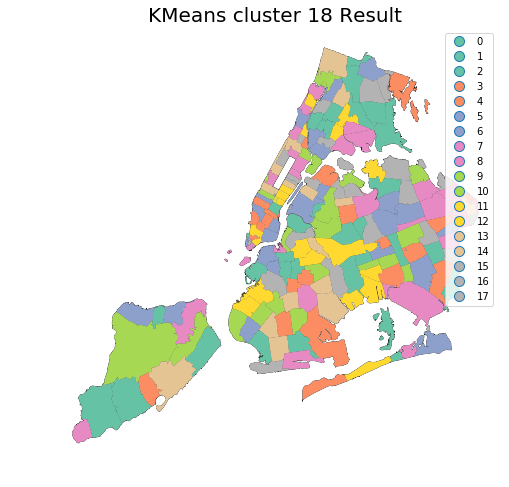

-------------------------------------------------------------------------


In [62]:
df = pd.read_csv("yearlydata/petit_larceny.csv")
print("----- petit_larceny -----")
df1 = df
df1['zipcode'] = df1['zipcode'].astype('str')
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)
X = df1.iloc[:,1:]
mean = X.mean(axis=1)
std = X.std(axis=1)
# print(std)
X = X.apply(lambda x: (x - mean) / std)
# print(X)
range_n_clusters = range(2,20)
X.reset_index(drop=True, inplace=True)
X.fillna(0, inplace=True)
    
best_cluster = find_best_cluster(X)[0]

timespan = df1.shape[1]
plot_result(best_cluster, timespan)
    
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
df1.to_csv("cluster_petit_larceny.csv")
print("-------------------------------------------------------------------------")

----- robbery -----
For n_clusters = 2, the average silhouette_score is : 0.31559608747504947
For n_clusters = 3, the average silhouette_score is : 0.34219082453237726
For n_clusters = 4, the average silhouette_score is : 0.3768742069143394
For n_clusters = 5, the average silhouette_score is : 0.36873905057452844
For n_clusters = 6, the average silhouette_score is : 0.39276253035917136
For n_clusters = 7, the average silhouette_score is : 0.39894030692592614
For n_clusters = 8, the average silhouette_score is : 0.4086335980262796
For n_clusters = 9, the average silhouette_score is : 0.41888175642606557
For n_clusters = 10, the average silhouette_score is : 0.4266190237617299
For n_clusters = 11, the average silhouette_score is : 0.44213961729966905
For n_clusters = 12, the average silhouette_score is : 0.4458701133753756
For n_clusters = 13, the average silhouette_score is : 0.43693321839474747
For n_clusters = 14, the average silhouette_score is : 0.4506883746684287
For n_clusters = 1

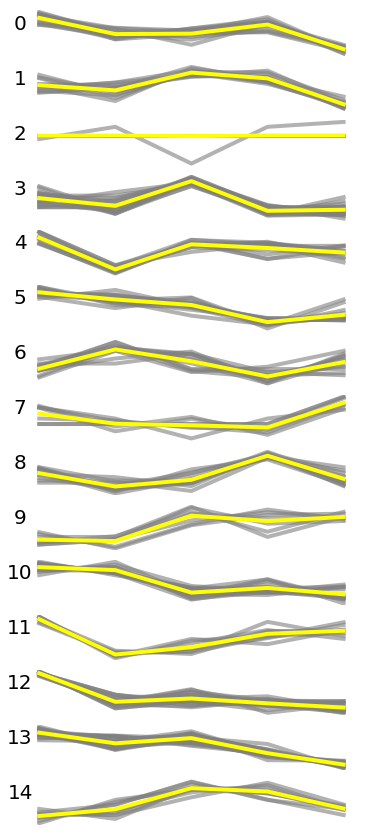

Total 248 zipcodes


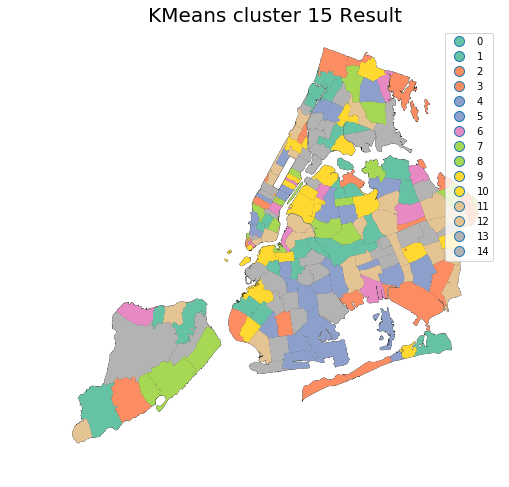

-------------------------------------------------------------------------


In [63]:
df = pd.read_csv("yearlydata/robbery.csv")
print("----- robbery -----")
df1 = df
df1['zipcode'] = df1['zipcode'].astype('str')
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)
X = df1.iloc[:,1:]
mean = X.mean(axis=1)
std = X.std(axis=1)
# print(std)
X = X.apply(lambda x: (x - mean) / std)
# print(X)
range_n_clusters = range(2,20)
X.reset_index(drop=True, inplace=True)
X.fillna(0, inplace=True)
    
best_cluster = find_best_cluster(X)[0]

timespan = df1.shape[1]
plot_result(best_cluster, timespan)
    
df1.drop(df1.columns[1:-1], axis=1, inplace=True)
df1.to_csv("cluster_robbery.csv")
print("-------------------------------------------------------------------------")